# New Section

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold,cross_val_score, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, make_scorer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier



In [167]:
df = pd.read_csv('depression_data.csv')
print(df.head())

# Check for basic information about the dataset
df.info()

# Get basic statistics for numerical columns
df.describe()

# Check for missing values
print("Missing values before preprocessing:\n", df.isnull().sum())
from sklearn.preprocessing import MinMaxScaler
df_dp = pd.DataFrame(df)

# Initialize the Min-Max scaler
scaler = MinMaxScaler()

# Scale the 'income' column
# df_dp['scaled_income'] = scaler.fit_transform(df_dp[['Income']])
# print(df_dp['scaled_income'])

df_dp['salary_category'] = pd.qcut(df['Income'], q=3, labels=[0, 1, 2])
df_dp['age_category'] = pd.qcut(df['Age'], q=3, labels=[0, 1, 2])


print(df_dp.head())


               Name  Age Marital Status    Education Level  \
0  Christine Barker   31        Married  Bachelor's Degree   
1  Jacqueline Lewis   55        Married        High School   
2    Shannon Church   78        Widowed    Master's Degree   
3    Charles Jordan   58       Divorced    Master's Degree   
4      Michael Rich   18         Single        High School   

   Number of Children Smoking Status Physical Activity Level  \
0                   2     Non-smoker                  Active   
1                   1     Non-smoker               Sedentary   
2                   1     Non-smoker               Sedentary   
3                   3     Non-smoker                Moderate   
4                   0     Non-smoker               Sedentary   

  Employment Status     Income Alcohol Consumption Dietary Habits  \
0        Unemployed   26265.67            Moderate       Moderate   
1          Employed   42710.36                High      Unhealthy   
2          Employed  125332.79     

In [178]:
X = df_dp.drop(columns=['Name', 'History of Mental Illness', 'Income', 'Age']) # Features
y = df_dp['History of Mental Illness']  # Target variable

# Label encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_dp['History of Mental Illness'])  # 'Yes' -> 1, 'No' -> 0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23382593 )
# Identify categorical and numerical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numerical_features = X.select_dtypes(exclude=['object']).columns.tolist()


# Create a preprocessor with OneHotEncoder for categorical features and StandardScaler for numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())]), numerical_features),
        ('cat', Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                                ('onehot', OneHotEncoder(handle_unknown='ignore'))]), categorical_features)
    ])

In [179]:
# Compute class weights to address class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weight_dict = dict(zip(np.unique(y), class_weights))

In [180]:

# Create a pipeline with preprocessor and model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', RandomForestClassifier(random_state= 23382593, class_weight=class_weight_dict))])


In [181]:

# Fit model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Number of Children',
                                                   'salary_category',
                                                   'age_category']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Marital Status',
                                                   'Education Level',
                                                   'Smoking Status',
                                                   'Physical Activity Level',
                                                   'Employment Status',
                                                   'Alcohol Consumption',
                                                   'Dietary Habits',
                                                   'Sleep Patterns',
                                                   'History of Substance Abuse',
                                                   'Family History of '
                                                   'Depression',
                                                   'Chronic Medical '
                                                   'Conditions'])])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 0.7169730348329876,
                                                      1: 1.6522169111587275},
                                        random_state=23382593))])

In [182]:
# Make predictions
y_pred = pipeline.predict(X_test)

In [183]:
# Evaluate model
accuracy = pipeline.score(X_test, y_test)
print(f'Model Accuracy: {accuracy:.2f}')

Model Accuracy: 0.66


In [184]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))



Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.84      0.78      2840
           1       0.34      0.20      0.25      1170

    accuracy                           0.66      4010
   macro avg       0.53      0.52      0.51      4010
weighted avg       0.61      0.66      0.62      4010



In [185]:
# Create a smaller sample of the data for testing purposes (e.g., 10% of the dataset)
X_sample, _, y_sample, _ = train_test_split(X, y, test_size=0.9, random_state=23382593)
cv_scores = cross_val_score(pipeline, X_sample, y_sample, cv=cv, scoring='accuracy')


In [186]:
print(f"\nCross-Validation Accuracy: Mean = {cv_scores.mean():.2f}, Std = {cv_scores.std():.2f}")


Cross-Validation Accuracy: Mean = 0.68, Std = 0.01


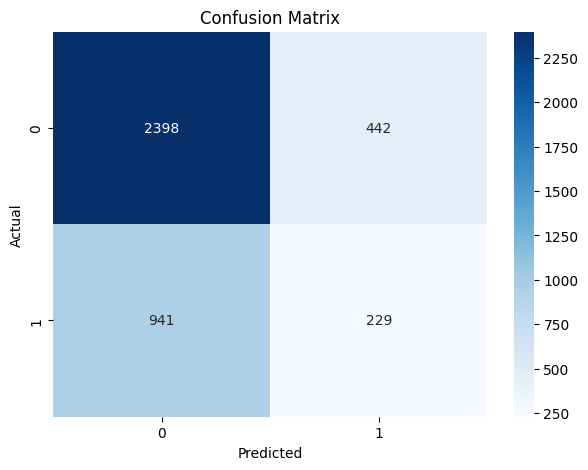

In [187]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importances:
                          Feature  Importance
0             Number of Children    0.132823
2                   age_category    0.076716
1                salary_category    0.043345
22  Alcohol Consumption_Moderate    0.036020
21       Alcohol Consumption_Low    0.034902


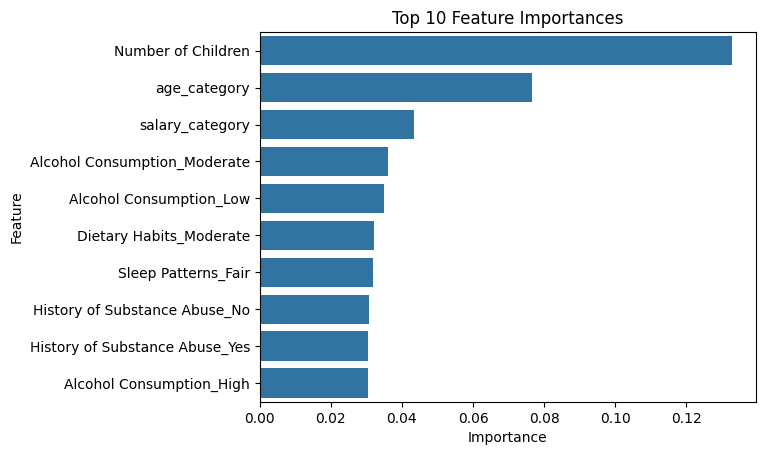

In [188]:
# Feature importance analysis
classifier = pipeline.named_steps['classifier']
if hasattr(classifier, 'feature_importances_'):
    feature_importances = classifier.feature_importances_
    feature_names = numerical_features + list(pipeline.named_steps['preprocessor'].
                                              named_transformers_['cat'].
                                              named_steps['onehot'].
                                              get_feature_names_out(categorical_features))
    feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)
    print("Feature Importances:\n", feature_imp_df.head())

    # Plot feature importance
    sns.barplot(x='Importance', y='Feature', data=feature_imp_df.head(10))
    plt.title('Top 10 Feature Importances')
    plt.show()
else:
    print("Feature importance not available for the chosen classifier.")


KNN

In [189]:

from sklearn.neighbors import KNeighborsClassifier


In [190]:

# Fit the preprocessor on training data and transform both training and testing data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)


In [191]:
from sklearn.metrics import accuracy_score
import random

num_features = X_train_transformed.shape[1]
sample_size = X_train_transformed.shape[0]
k_values = list(range(1, 70, 2))


accuracies = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_transformed, y_train)
    y_pred = knn.predict(X_test_transformed)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

print("Found all accurracy for different K values")
print(len(accuracies), len(k_values))

Found all accurracy for different K values
35 35


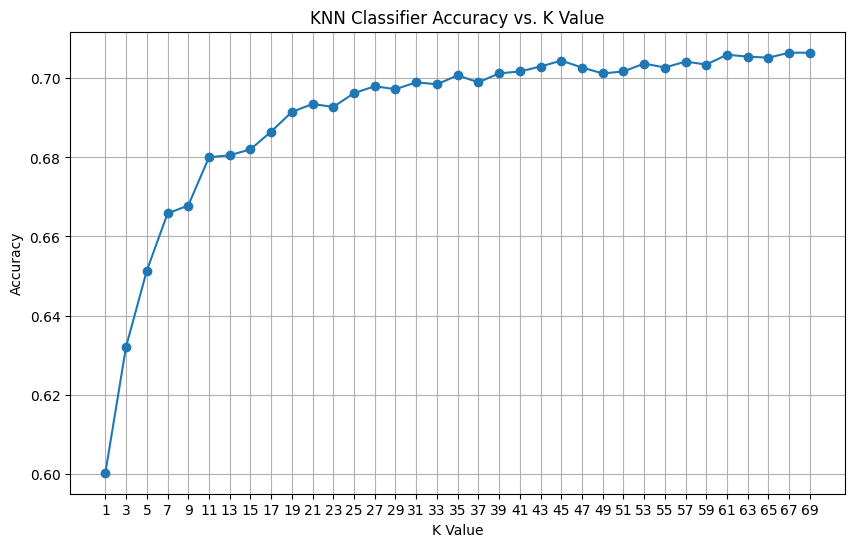

In [192]:
# Plotting accuracy vs. K values
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title('KNN Classifier Accuracy vs. K Value')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [193]:
# Print results and find the best K value
best_k_index = np.argmax(accuracies)
best_k_value = k_values[best_k_index]
best_accuracy = accuracies[best_k_index]

In [194]:
for k, acc in zip(k_values, accuracies):
    print(f'Accuracy for K={k}: {acc:.4f}')

print(f'\nBest K Value: {best_k_value} with Accuracy: {best_accuracy:.4f}')


Accuracy for K=1: 0.6002
Accuracy for K=3: 0.6322
Accuracy for K=5: 0.6514
Accuracy for K=7: 0.6658
Accuracy for K=9: 0.6678
Accuracy for K=11: 0.6800
Accuracy for K=13: 0.6805
Accuracy for K=15: 0.6820
Accuracy for K=17: 0.6865
Accuracy for K=19: 0.6915
Accuracy for K=21: 0.6935
Accuracy for K=23: 0.6928
Accuracy for K=25: 0.6963
Accuracy for K=27: 0.6980
Accuracy for K=29: 0.6973
Accuracy for K=31: 0.6990
Accuracy for K=33: 0.6985
Accuracy for K=35: 0.7007
Accuracy for K=37: 0.6990
Accuracy for K=39: 0.7012
Accuracy for K=41: 0.7017
Accuracy for K=43: 0.7030
Accuracy for K=45: 0.7045
Accuracy for K=47: 0.7027
Accuracy for K=49: 0.7012
Accuracy for K=51: 0.7017
Accuracy for K=53: 0.7037
Accuracy for K=55: 0.7027
Accuracy for K=57: 0.7042
Accuracy for K=59: 0.7035
Accuracy for K=61: 0.7060
Accuracy for K=63: 0.7055
Accuracy for K=65: 0.7052
Accuracy for K=67: 0.7065
Accuracy for K=69: 0.7065

Best K Value: 67 with Accuracy: 0.7065


In [195]:
# Detailed classification report for the best model
print("\nClassification Report for Best Model:")
best_knn = KNeighborsClassifier(n_neighbors=best_k_value)
best_knn.fit(X_train_transformed, y_train)
y_pred_best = best_knn.predict(X_test_transformed)

print(classification_report(y_test, y_pred_best))


Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.71      0.99      0.83      2840
           1       0.41      0.01      0.03      1170

    accuracy                           0.71      4010
   macro avg       0.56      0.50      0.43      4010
weighted avg       0.62      0.71      0.59      4010



**knn confusion matrix**

Confusion Matrix:


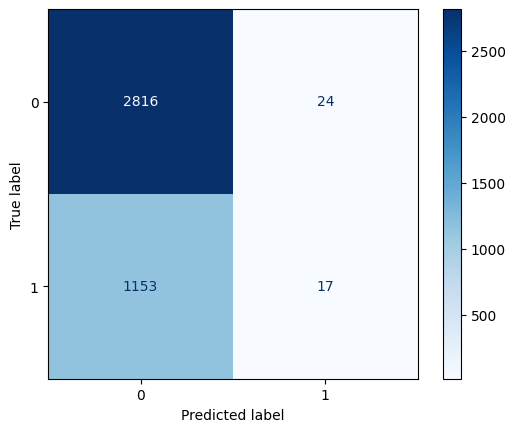

In [196]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best)

# Print the confusion matrix
print("Confusion Matrix:")
cm_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=np.unique(y_test))

cm_display.plot(cmap='Blues', values_format='d')


In [202]:
# Evaluate the best model
final_mse = mean_squared_error(y_test, y_pred_best)
final_mae = mean_absolute_error(y_test, y_pred_best)
final_rmse = np.sqrt(final_mse)
print(f"Final Model with k={best_k_value}:")
print(f"Mean Absolute Error (MAE): {final_mae:.2f}")
print(f"Mean Squared Error (MSE): {final_mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {final_rmse:.2f}")



Final Model with k=67:
Mean Absolute Error (MAE): 0.31
Mean Squared Error (MSE): 0.31
Root Mean Squared Error (RMSE): 0.55
